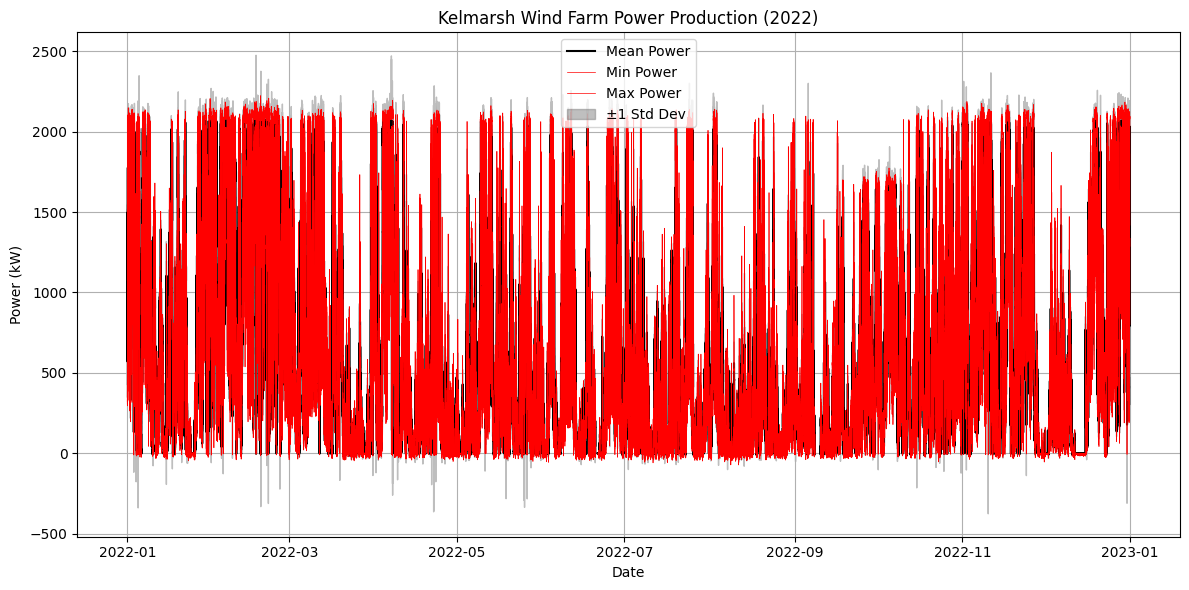

In [14]:
"""Part 1: Load and plot input data"""
# -------------------------------
# 1. Load Data and Initial Plot
# -------------------------------

import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV with timestamp index
df = pd.read_csv('./km_scada_sample_2022.csv', index_col=0, parse_dates=True)

# -------------------------------
# 2. Plot Power Time Series
# -------------------------------

plt.figure(figsize=(12, 6))

# Plot mean power (central line)
plt.plot(df.index, df['Power (kW)'], color='black', label='Mean Power')

# Plot min and max power (bounds)
plt.plot(df.index, df['Power, Minimum (kW)'], color='red', linewidth=0.5, label='Min Power')
plt.plot(df.index, df['Power, Maximum (kW)'], color='red', linewidth=0.5, linestyle='--', label='Max Power')

# Plot ±1 standard deviation as shaded area
plt.fill_between(df.index,
                 df['Power (kW)'] - df['Power, Standard deviation (kW)'],
                 df['Power (kW)'] + df['Power, Standard deviation (kW)'],
                 color='gray', alpha=0.5, label='±1 Std Dev')

# Plot formatting
plt.title('Kelmarsh Wind Farm Power Production (2022)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power (kW)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [31]:
"""Part 2: Prep Data for Pytorch"""
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch

# -------------------------------
# Configuration
# -------------------------------
window_size = 18   # Length of input sequence for LSTM
step_ahead = 1     # Forecast horizon (steps ahead)
target_col = 'Power (kW)'  # Column to predict

# -------------------------------
# 1. Time-Based Train/Valid/Test Split
# -------------------------------

# Get the first timestamp
start_date = df.index.min()

# Dynamically define the split boundaries
train_end = start_date + pd.DateOffset(months=9)
valid_end = train_end + pd.DateOffset(months=2)

# Perform chronological split
train = df.loc[start_date:train_end - pd.Timedelta(minutes=10)]
valid = df.loc[train_end:valid_end - pd.Timedelta(minutes=10)]
test  = df.loc[valid_end:]

# -------------------------------
# 2. Normalize Target Column Using MinMaxScaler
# -------------------------------

# Initialize scaler and fit only on training data (to prevent data leakage)
scaler = MinMaxScaler()
train_series = scaler.fit_transform(train[[target_col]])
valid_series = scaler.transform(valid[[target_col]])
test_series  = scaler.transform(test[[target_col]])

# -------------------------------
# 3. Windowing Function for Sequence Creation
# -------------------------------

def create_windows(series, window_size=window_size, step_ahead=1):
    """
    Convert a 1D time series into input/output pairs using sliding windows.
    
    Args:
        series (np.ndarray): Scaled time series of shape (N, 1)
        window_size (int): Length of input sequence for LSTM
        step_ahead (int): Forecast horizon (default 1-step ahead)
        
    Returns:
        X (np.ndarray): Shape (samples, window_size, 1)
        y (np.ndarray): Shape (samples, 1)
    """
    X, y = [], []
    for i in range(len(series) - window_size - step_ahead + 1):
        X.append(series[i : i + window_size])
        y.append(series[i + window_size + step_ahead - 1])
    return np.array(X), np.array(y)

# Create input-output windows for each data split
X_train, y_train = create_windows(train_series)
X_valid, y_valid = create_windows(valid_series)
X_test,  y_test  = create_windows(test_series)

# -------------------------------
# 4. Convert to PyTorch Tensors
# -------------------------------

# Convert to float32 tensors; PyTorch expects shape (batch, seq_len, input_dim)
X_train_t = torch.tensor(X_train, dtype=torch.float32)  # Shape: (N, window_size, 1)
y_train_t = torch.tensor(y_train, dtype=torch.float32)  # Shape: (N, 1)
X_valid_t = torch.tensor(X_valid, dtype=torch.float32)
y_valid_t = torch.tensor(y_valid, dtype=torch.float32)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32)

# Sanity check
print(f"Train shape: {X_train_t.shape}, {y_train_t.shape}")
print(f"Valid shape: {X_valid_t.shape}, {y_valid_t.shape}")
print(f"Test shape:  {X_test_t.shape},  {y_test_t.shape}")

Train shape: torch.Size([39294, 18, 1]), torch.Size([39294, 1])
Valid shape: torch.Size([8766, 18, 1]), torch.Size([8766, 1])
Test shape:  torch.Size([4446, 18, 1]),  torch.Size([4446, 1])


In [34]:
"""Part 3: Train LSTM model, find best set of hyperparams and save best model. """
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from itertools import product
from tqdm import tqdm
import random

# -------------------------------
# 1. LSTM Model Definition
# -------------------------------

class LSTMPredictor(nn.Module):
    """
    A simple LSTM-based regressor for time series prediction.
    """
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # LSTM output: (batch, seq_len, hidden_size)
        lstm_out, _ = self.lstm(x)
        # Use the last time step's output
        out = self.linear(lstm_out[:, -1, :])
        return out

# -------------------------------
# 2. Training and Evaluation Function
# -------------------------------

def train_and_eval_model(hp, X_train_t, y_train_t, X_valid_t, y_valid_t, num_epochs):
    """
    Train and evaluate LSTM model with given hyperparameters.
    
    Args:
        hp (dict): Hyperparameters (hidden_size, num_layers, lr, batch_size)
        X_train_t, y_train_t: Training tensors
        X_valid_t, y_valid_t: Validation tensors
        num_epochs (int): Number of epochs to train
    
    Returns:
        val_loss (float): Final validation loss
        model (nn.Module): Trained model
        hp (dict): Used hyperparameters
    """
    input_size = X_train_t.shape[2]

    # Unpack hyperparameters
    hidden_size = hp['hidden_size']
    num_layers = hp['num_layers']
    lr = hp['lr']
    batch_size = hp['batch_size']

    # Initialize model, loss function, optimizer
    model = LSTMPredictor(input_size, hidden_size, num_layers)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Create data loaders
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(TensorDataset(X_valid_t, y_valid_t), batch_size=batch_size)

    # -------------------------------
    # Training Loop
    # -------------------------------
    model.train()
    for epoch in tqdm(range(num_epochs), desc="Training"):
        for X_batch, y_batch in train_loader:
            if torch.isnan(X_batch).any() or torch.isnan(y_batch).any():
                continue  # Skip invalid batches
            pred = model(X_batch)
            loss = loss_fn(pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # -------------------------------
    # Validation Loop
    # -------------------------------
    model.eval()
    total_loss = 0
    n_batches = 0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            if torch.isnan(X_batch).any() or torch.isnan(y_batch).any():
                continue
            pred = model(X_batch)
            loss = loss_fn(pred, y_batch)
            total_loss += loss.item()
            n_batches += 1

    val_loss = total_loss / n_batches if n_batches > 0 else float('inf')
    return val_loss, model, hp

# -------------------------------
# 3. Hyperparameter Random Search Setup
# -------------------------------

# Define hyperparameter grid
param_grid = {
    'hidden_size': [8, 16, 32],
    'num_layers': [1, 2],
    'lr': [0.001, 0.0005],
    'batch_size': [32, 64]
}
num_epochs = 200
n_trials = 2  # <-- How many random combinations to test

# Create all possible combinations
all_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

# Randomly sample without replacement
random.seed(42)  # For reproducibility
sampled_combinations = random.sample(all_combinations, k=min(n_trials, len(all_combinations)))

# Track best model
best_loss = float('inf')
best_model = None
best_hps = None

# -------------------------------
# 4. Random Hyperparameter Search
# -------------------------------

for hparams in sampled_combinations:
    hps = dict(zip(param_names, hparams))
    val_loss, model, used_hps = train_and_eval_model(hps, X_train_t, y_train_t, X_valid_t, y_valid_t, num_epochs)
    
    print(f"Tested {used_hps}, Validation Loss: {val_loss:.4f}")
    
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model
        best_hps = used_hps

# -------------------------------
# 5. Final Report
# -------------------------------

print("\nBest Hyperparameters:")
print(best_hps)
print(f"Validation Loss: {best_loss:.4f}")


Training: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [09:36<00:00,  2.88s/it]


Tested {'hidden_size': 32, 'num_layers': 2, 'lr': 0.001, 'batch_size': 32}, Validation Loss: 0.0060


Training: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [02:43<00:00,  1.22it/s]

Tested {'hidden_size': 8, 'num_layers': 1, 'lr': 0.0005, 'batch_size': 64}, Validation Loss: 0.0059

Best Hyperparameters:
{'hidden_size': 8, 'num_layers': 1, 'lr': 0.0005, 'batch_size': 64}
Validation Loss: 0.0059


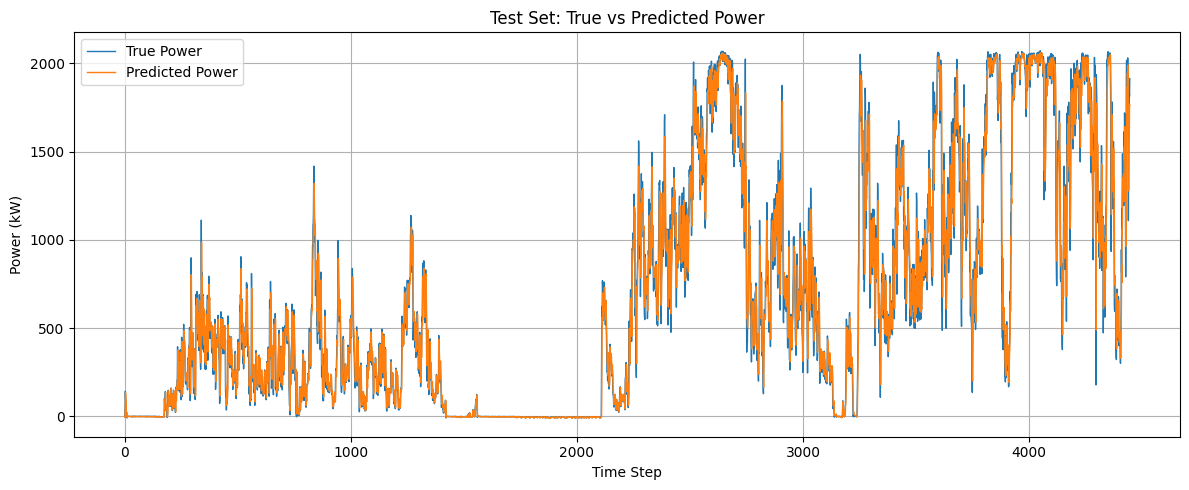

In [35]:
"""Part 4: Present Results """
import matplotlib.pyplot as plt
import torch

# -------------------------------
# Plotting Function: True vs Predicted
# -------------------------------

def plot_predictions(model, X, y, scaler, split_name='valid'):
    """
    Plot true vs predicted values for a given dataset split.

    Args:
        model (nn.Module): Trained PyTorch model
        X (np.ndarray or torch.Tensor): Input sequences
        y (np.ndarray or torch.Tensor): Ground truth target values
        scaler (MinMaxScaler): Fitted scaler used for inverse transformation
        split_name (str): Label for plot ('train', 'valid', or 'test')
    """
    model.eval()

    # Convert inputs to tensors if needed
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X, dtype=torch.float32)
    if not isinstance(y, torch.Tensor):
        y = torch.tensor(y, dtype=torch.float32)

    # Ensure correct shape: LSTM expects 3D inputs
    if X.ndim == 2:
        X = X.unsqueeze(-1)
    if y.ndim == 1:
        y = y.unsqueeze(-1)

    # Get model predictions
    with torch.no_grad():
        y_pred_t = model(X)

    # Detach and convert to NumPy for plotting
    y_pred = y_pred_t.detach().cpu().numpy()
    y_true = y.detach().cpu().numpy()

    # Inverse transform back to original kW scale
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_true_inv = scaler.inverse_transform(y_true)

    # -------------------------------
    # Plotting
    # -------------------------------
    plt.figure(figsize=(12, 5))
    plt.plot(y_true_inv, label='True Power', linewidth=1)
    plt.plot(y_pred_inv, label='Predicted Power', linewidth=1)
    plt.title(f'{split_name.capitalize()} Set: True vs Predicted Power')
    plt.xlabel('Time Step')
    plt.ylabel('Power (kW)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Choose which dataset split to plot
split = "test"  # Options: "train", "valid", "test"

# Call plot_predictions with correct data
if split == "train":
    plot_predictions(best_model, X_train, y_train, scaler, split_name='train')
elif split == "valid":
    plot_predictions(best_model, X_valid, y_valid, scaler, split_name='valid')
elif split == "test":
    plot_predictions(best_model, X_test, y_test, scaler, split_name='test')
else:
    print("❌ Invalid split name. Choose from 'train', 'valid', or 'test'.")

